In [1]:
import numpy as np
import tensorflow as tf

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import GRU, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import metrics

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
# Define model architecture for 48hr data
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(48,22)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.AUC()])

# Print model summary
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 48, 30)            4770      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1440)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                57640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
__________________________

In [3]:
# Load the data
_data = np.load('res/data.npy', allow_pickle=True).tolist()
X_train = _data['X_train_norm']
y_train = _data['y_train']
X_val = _data['X_val_norm']
y_val = _data['y_val']
X_test = _data['X_test_norm']
y_test = _data['y_test']
print("Loaded!")

Loaded!


In [4]:
# Print information about the created arrays
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of patients who died in hospital in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of patients who died in hospital in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 38549
No. of patients in train, val, test sets: 30839, 3855, 3855
No. of patients who died in hospital in train, val, test sets: 3458.0, 417.0, 445.0
Proportion of patients who died in hospital in train, val, test sets: 11.213%, 10.817%, 11.543%


In [5]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (30839, 22, 48)
y_train: (30839,)
X_val: (3855, 22, 48)
y_val: (3855,)
X_test: (3855, 22, 48)
y_test: (3855,)


In [6]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [7]:
# Check the shapes of the arrays again
print("X_train: {}".format(np.shape(X_train)))
print("X_val: {}".format(np.shape(X_val)))
print("X_test: {}".format(np.shape(X_test)))

X_train: (30839, 48, 22)
X_val: (3855, 48, 22)
X_test: (3855, 48, 22)


In [8]:
# Define the early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=100, verbose=1, callbacks=[es])


Train on 30839 samples, validate on 3855 samples
Epoch 1/250
30839/30839 [==============================] - 16s 505us/step - loss: 0.5842 - auc_1: 0.8538 - val_loss: 0.4927 - val_auc_1: 0.8853
Epoch 2/250
30839/30839 [==============================] - 13s 437us/step - loss: 0.4688 - auc_1: 0.8808 - val_loss: 0.4290 - val_auc_1: 0.8908
Epoch 3/250
30839/30839 [==============================] - 13s 426us/step - loss: 0.3967 - auc_1: 0.8939 - val_loss: 0.3525 - val_auc_1: 0.8990
Epoch 4/250
30839/30839 [==============================] - 14s 439us/step - loss: 0.3445 - auc_1: 0.9005 - val_loss: 0.3205 - val_auc_1: 0.9069
Epoch 5/250
30839/30839 [==============================] - 13s 435us/step - loss: 0.3077 - auc_1: 0.9095 - val_loss: 0.2867 - val_auc_1: 0.9074
Epoch 6/250
30839/30839 [==============================] - 13s 433us/step - loss: 0.2799 - auc_1: 0.9140 - val_loss: 0.2845 - val_auc_1: 0.9083
Epoch 7/250
30839/30839 [==============================] - 13s 427us/step - loss: 0.25

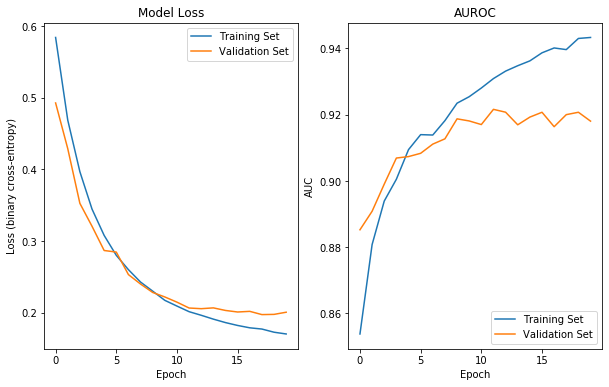

In [9]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(10,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the AUC
ax2.plot(history.history['auc_1'])
ax2.plot(history.history['val_auc_1'])
ax2.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [10]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_48h = model.predict(X_test).ravel()
fpr_48h, tpr_48h, thresholds_48h = roc_curve(y_test, y_pred_48h)

In [11]:
# Calculate the AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_48h = auc(fpr_48h, tpr_48h)

In [12]:
# Define model architecture for 48hr (balanced) data
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(48,22)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 48, 30)            4770      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1440)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                57640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                

In [13]:
# Load the data
_data = np.load('res/data.npy', allow_pickle=True).tolist()
X_train = _data['X_train_norm_bal']
y_train = _data['y_train_bal']
X_val = _data['X_val_norm']
y_val = _data['y_val']
X_test = _data['X_test_norm']
y_test = _data['y_test']
print("Loaded!")

Loaded!


In [14]:
# Print information about the created arrays
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of patients who died in hospital in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of patients who died in hospital in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 59297
No. of patients in train, val, test sets: 51587, 3855, 3855
No. of patients who died in hospital in train, val, test sets: 24206.0, 417.0, 445.0
Proportion of patients who died in hospital in train, val, test sets: 46.923%, 10.817%, 11.543%


In [15]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (51587, 22, 48)
y_train: (51587,)
X_val: (3855, 22, 48)
y_val: (3855,)
X_test: (3855, 22, 48)
y_test: (3855,)


In [16]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [17]:
# Check the shapes of the arrays again
print("X_train: {}".format(np.shape(X_train)))
print("X_val: {}".format(np.shape(X_val)))
print("X_test: {}".format(np.shape(X_test)))

X_train: (51587, 48, 22)
X_val: (3855, 48, 22)
X_test: (3855, 48, 22)


In [18]:
# Define the early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=100, verbose=1, callbacks=[es])

Train on 51587 samples, validate on 3855 samples
Epoch 1/250
51587/51587 [==============================] - 24s 466us/step - loss: 0.4369 - auc_2: 0.8955 - val_loss: 0.3912 - val_auc_2: 0.9136
Epoch 2/250
51587/51587 [==============================] - 23s 440us/step - loss: 0.3719 - auc_2: 0.9213 - val_loss: 0.3412 - val_auc_2: 0.9145
Epoch 3/250
51587/51587 [==============================] - 22s 431us/step - loss: 0.3427 - auc_2: 0.9305 - val_loss: 0.3504 - val_auc_2: 0.9176
Epoch 4/250
51587/51587 [==============================] - 22s 428us/step - loss: 0.3220 - auc_2: 0.9372 - val_loss: 0.3450 - val_auc_2: 0.9241


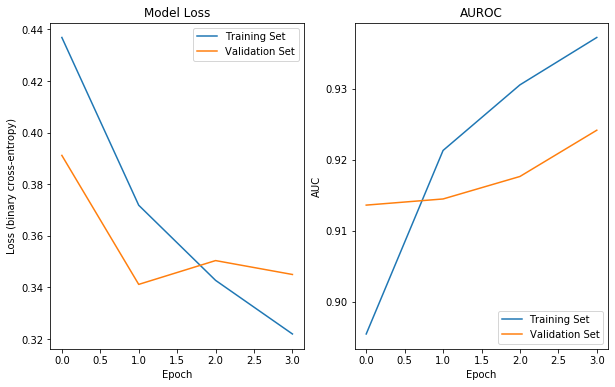

In [19]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(10,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the AUC
ax2.plot(history.history['auc_2'])
ax2.plot(history.history['val_auc_2'])
ax2.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [20]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_48h_bal = model.predict(X_test).ravel()
fpr_48h_bal, tpr_48h_bal, thresholds_48h_bal = roc_curve(y_test, y_pred_48h_bal)

In [21]:
# Calculate the AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_48h_bal = auc(fpr_48h_bal, tpr_48h_bal)

In [22]:
# Define model architecture for day 1 data
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,22)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 24, 30)            4770      
_________________________________________________________________
flatten_3 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
_________________________________________________________________
batch_normalization_3 (Batch (None, 1)                

In [23]:
# Load the data
_data = np.load('res/data.npy', allow_pickle=True).tolist()
X_train = _data['D1_X_train_norm']
y_train = _data['y_train']
X_val = _data['D1_X_val_norm']
y_val = _data['y_val']
X_test = _data['D1_X_test_norm']
y_test = _data['y_test']
print("Loaded!")

Loaded!


In [24]:
# Print information about the created arrays
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of patients who died in hospital in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of patients who died in hospital in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 38549
No. of patients in train, val, test sets: 30839, 3855, 3855
No. of patients who died in hospital in train, val, test sets: 3458.0, 417.0, 445.0
Proportion of patients who died in hospital in train, val, test sets: 11.213%, 10.817%, 11.543%


In [25]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (30839, 22, 24)
y_train: (30839,)
X_val: (3855, 22, 24)
y_val: (3855,)
X_test: (3855, 22, 24)
y_test: (3855,)


In [26]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [27]:
# Check the shapes of the arrays again
print("X_train: {}".format(np.shape(X_train)))
print("X_val: {}".format(np.shape(X_val)))
print("X_test: {}".format(np.shape(X_test)))

X_train: (30839, 24, 22)
X_val: (3855, 24, 22)
X_test: (3855, 24, 22)


In [28]:
# Define the early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=100, verbose=1, callbacks=[es])

Train on 30839 samples, validate on 3855 samples
Epoch 1/250
30839/30839 [==============================] - 9s 305us/step - loss: 0.6040 - auc_3: 0.8317 - val_loss: 0.4935 - val_auc_3: 0.8640
Epoch 2/250
30839/30839 [==============================] - 8s 246us/step - loss: 0.4888 - auc_3: 0.8576 - val_loss: 0.4274 - val_auc_3: 0.8678
Epoch 3/250
30839/30839 [==============================] - 7s 243us/step - loss: 0.4161 - auc_3: 0.8709 - val_loss: 0.3958 - val_auc_3: 0.8805
Epoch 4/250
30839/30839 [==============================] - 7s 239us/step - loss: 0.3635 - auc_3: 0.8846 - val_loss: 0.3266 - val_auc_3: 0.8908
Epoch 5/250
30839/30839 [==============================] - 7s 231us/step - loss: 0.3259 - auc_3: 0.8894 - val_loss: 0.3170 - val_auc_3: 0.8925
Epoch 6/250
30839/30839 [==============================] - 8s 244us/step - loss: 0.2960 - auc_3: 0.9006 - val_loss: 0.2842 - val_auc_3: 0.9000- loss: 0.29
Epoch 7/250
30839/30839 [==============================] - 7s 230us/step - loss: 

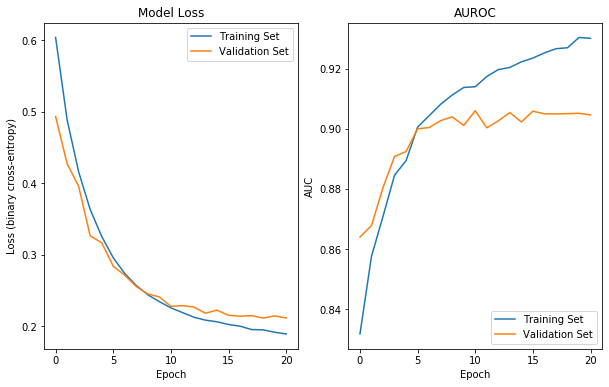

In [29]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(10,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the AUC
ax2.plot(history.history['auc_3'])
ax2.plot(history.history['val_auc_3'])
ax2.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [30]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_D1 = model.predict(X_test).ravel()
fpr_D1, tpr_D1, thresholds_D1 = roc_curve(y_test, y_pred_D1)

In [31]:
# Calculate the AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_D1 = auc(fpr_D1, tpr_D1)

In [32]:
# Define model architecture for day 1 (balanced) data
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,22)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 24, 30)            4770      
_________________________________________________________________
flatten_4 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_8 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 41        
_________________________________________________________________
batch_normalization_4 (Batch (None, 1)                

In [33]:
# Load the data
_data = np.load('res/data.npy', allow_pickle=True).tolist()
X_train = _data['D1_X_train_norm_bal']
y_train = _data['y_train_bal']
X_val = _data['D1_X_val_norm']
y_val = _data['y_val']
X_test = _data['D1_X_test_norm']
y_test = _data['y_test']
print("Loaded!")

Loaded!


In [34]:
# Print information about the created arrays
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of patients who died in hospital in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of patients who died in hospital in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 59297
No. of patients in train, val, test sets: 51587, 3855, 3855
No. of patients who died in hospital in train, val, test sets: 24206.0, 417.0, 445.0
Proportion of patients who died in hospital in train, val, test sets: 46.923%, 10.817%, 11.543%


In [35]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (51587, 22, 24)
y_train: (51587,)
X_val: (3855, 22, 24)
y_val: (3855,)
X_test: (3855, 22, 24)
y_test: (3855,)


In [36]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [37]:
# Check the shapes of the arrays again
print("X_train: {}".format(np.shape(X_train)))
print("X_val: {}".format(np.shape(X_val)))
print("X_test: {}".format(np.shape(X_test)))

X_train: (51587, 24, 22)
X_val: (3855, 24, 22)
X_test: (3855, 24, 22)


In [38]:
# Define the early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=100, verbose=1, callbacks=[es])

Train on 51587 samples, validate on 3855 samples
Epoch 1/250
51587/51587 [==============================] - 14s 277us/step - loss: 0.4592 - auc_4: 0.8785 - val_loss: 0.4485 - val_auc_4: 0.8942
Epoch 2/250
51587/51587 [==============================] - 12s 241us/step - loss: 0.3953 - auc_4: 0.9078 - val_loss: 0.3839 - val_auc_4: 0.89810s - loss: 0.3964 - auc
Epoch 3/250
51587/51587 [==============================] - 10s 195us/step - loss: 0.3687 - auc_4: 0.9176 - val_loss: 0.3761 - val_auc_4: 0.9037
Epoch 4/250
51587/51587 [==============================] - 8s 164us/step - loss: 0.3514 - auc_4: 0.9240 - val_loss: 0.3501 - val_auc_4: 0.8999
Epoch 5/250
51587/51587 [==============================] - 8s 158us/step - loss: 0.3396 - auc_4: 0.9280 - val_loss: 0.3489 - val_auc_4: 0.9048
Epoch 6/250
51587/51587 [==============================] - 8s 150us/step - loss: 0.3295 - auc_4: 0.9315 - val_loss: 0.3763 - val_auc_4: 0.9009
Epoch 7/250
51587/51587 [==============================] - 8s 148us

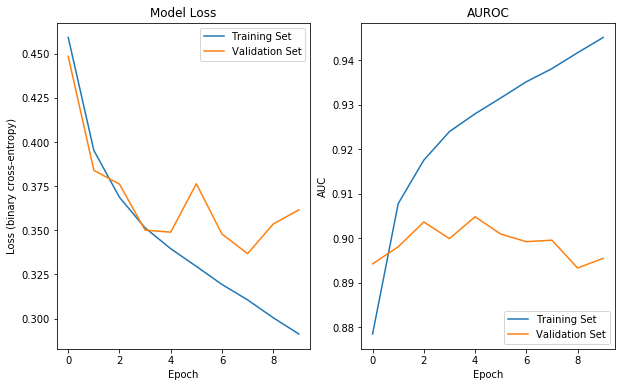

In [39]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(10,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the AUC
ax2.plot(history.history['auc_4'])
ax2.plot(history.history['val_auc_4'])
ax2.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [40]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_D1_bal = model.predict(X_test).ravel()
fpr_D1_bal, tpr_D1_bal, thresholds_D1_bal = roc_curve(y_test, y_pred_D1_bal)

In [41]:
# Calculate the AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_D1_bal = auc(fpr_D1_bal, tpr_D1_bal)

In [42]:
# Define model architecture for day 2 data
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,22)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 24, 30)            4770      
_________________________________________________________________
flatten_5 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_10 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 41        
_________________________________________________________________
batch_normalization_5 (Batch (None, 1)                

In [43]:
# Load the data
_data = np.load('res/data.npy', allow_pickle=True).tolist()
X_train = _data['D2_X_train_norm']
y_train = _data['y_train']
X_val = _data['D2_X_val_norm']
y_val = _data['y_val']
X_test = _data['D2_X_test_norm']
y_test = _data['y_test']
print("Loaded!")

Loaded!


In [44]:
# Print information about the created arrays
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of patients who died in hospital in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of patients who died in hospital in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 38549
No. of patients in train, val, test sets: 30839, 3855, 3855
No. of patients who died in hospital in train, val, test sets: 3458.0, 417.0, 445.0
Proportion of patients who died in hospital in train, val, test sets: 11.213%, 10.817%, 11.543%


In [45]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (30839, 22, 24)
y_train: (30839,)
X_val: (3855, 22, 24)
y_val: (3855,)
X_test: (3855, 22, 24)
y_test: (3855,)


In [46]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [47]:
# Check the shapes of the arrays again
print("X_train: {}".format(np.shape(X_train)))
print("X_val: {}".format(np.shape(X_val)))
print("X_test: {}".format(np.shape(X_test)))

X_train: (30839, 24, 22)
X_val: (3855, 24, 22)
X_test: (3855, 24, 22)


In [48]:
# Define the early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=100, verbose=1, callbacks=[es])

Train on 30839 samples, validate on 3855 samples
Epoch 1/250
30839/30839 [==============================] - 5s 164us/step - loss: 0.5796 - auc_5: 0.8595 - val_loss: 0.4936 - val_auc_5: 0.8812
Epoch 2/250
30839/30839 [==============================] - 5s 152us/step - loss: 0.4700 - auc_5: 0.8610 - val_loss: 0.4421 - val_auc_5: 0.8962
Epoch 3/250
30839/30839 [==============================] - 5s 151us/step - loss: 0.3989 - auc_5: 0.8848 - val_loss: 0.3549 - val_auc_5: 0.9031
Epoch 4/250
30839/30839 [==============================] - 5s 157us/step - loss: 0.3477 - auc_5: 0.8909 - val_loss: 0.3223 - val_auc_5: 0.9080
Epoch 5/250
30839/30839 [==============================] - 5s 149us/step - loss: 0.3117 - auc_5: 0.9031 - val_loss: 0.2947 - val_auc_5: 0.9112
Epoch 6/250
30839/30839 [==============================] - 5s 149us/step - loss: 0.2829 - auc_5: 0.9098 - val_loss: 0.2804 - val_auc_5: 0.9105
Epoch 7/250
30839/30839 [==============================] - 5s 149us/step - loss: 0.2625 - auc

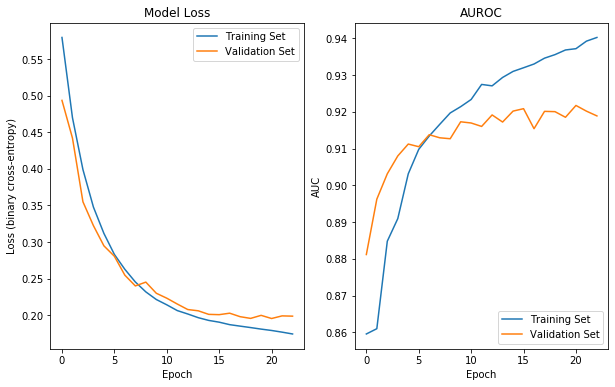

In [49]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(10,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the AUC
ax2.plot(history.history['auc_5'])
ax2.plot(history.history['val_auc_5'])
ax2.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [50]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_D2 = model.predict(X_test).ravel()
fpr_D2, tpr_D2, thresholds_D2 = roc_curve(y_test, y_pred_D2)

In [51]:
# Calculate the AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_D2 = auc(fpr_D2, tpr_D2)

In [52]:
# Define model architecture for day 2 (balanced) data
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,22)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 24, 30)            4770      
_________________________________________________________________
flatten_6 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 720)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 40)                28840     
_________________________________________________________________
dropout_12 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 41        
_________________________________________________________________
batch_normalization_6 (Batch (None, 1)                

In [53]:
# Load the data
_data = np.load('res/data.npy', allow_pickle=True).tolist()
X_train = _data['D2_X_train_norm_bal']
y_train = _data['y_train_bal']
X_val = _data['D2_X_val_norm']
y_val = _data['y_val']
X_test = _data['D2_X_test_norm']
y_test = _data['y_test']
print("Loaded!")

Loaded!


In [54]:
# Print information about the created arrays
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of patients who died in hospital in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of patients who died in hospital in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 59297
No. of patients in train, val, test sets: 51587, 3855, 3855
No. of patients who died in hospital in train, val, test sets: 24206.0, 417.0, 445.0
Proportion of patients who died in hospital in train, val, test sets: 46.923%, 10.817%, 11.543%


In [55]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (51587, 22, 24)
y_train: (51587,)
X_val: (3855, 22, 24)
y_val: (3855,)
X_test: (3855, 22, 24)
y_test: (3855,)


In [56]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [57]:
# Check the shapes of the arrays again
print("X_train: {}".format(np.shape(X_train)))
print("X_val: {}".format(np.shape(X_val)))
print("X_test: {}".format(np.shape(X_test)))

X_train: (51587, 24, 22)
X_val: (3855, 24, 22)
X_test: (3855, 24, 22)


In [58]:
# Define the early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=100, verbose=1, callbacks=[es])

Train on 51587 samples, validate on 3855 samples
Epoch 1/250
51587/51587 [==============================] - 8s 155us/step - loss: 0.4432 - auc_6: 0.8923 - val_loss: 0.3921 - val_auc_6: 0.9094
Epoch 2/250
51587/51587 [==============================] - 8s 147us/step - loss: 0.3787 - auc_6: 0.9182 - val_loss: 0.3452 - val_auc_6: 0.9162
Epoch 3/250
51587/51587 [==============================] - 8s 153us/step - loss: 0.3525 - auc_6: 0.9259 - val_loss: 0.3546 - val_auc_6: 0.9145
Epoch 4/250
51587/51587 [==============================] - 8s 147us/step - loss: 0.3368 - auc_6: 0.9312 - val_loss: 0.3281 - val_auc_6: 0.9147
Epoch 5/250
51587/51587 [==============================] - 8s 147us/step - loss: 0.3249 - auc_6: 0.9349 - val_loss: 0.3112 - val_auc_6: 0.9158
Epoch 6/250
51587/51587 [==============================] - 8s 149us/step - loss: 0.3159 - auc_6: 0.9382 - val_loss: 0.3239 - val_auc_6: 0.9170
Epoch 7/250
51587/51587 [==============================] - 8s 148us/step - loss: 0.3065 - auc

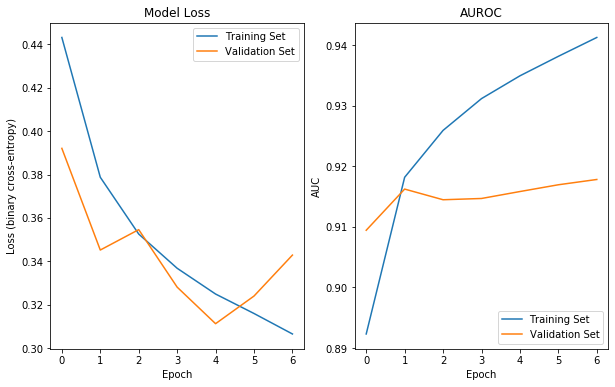

In [59]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(10,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the AUC
ax2.plot(history.history['auc_6'])
ax2.plot(history.history['val_auc_6'])
ax2.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [60]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_D2_bal = model.predict(X_test).ravel()
fpr_D2_bal, tpr_D2_bal, thresholds_D2_bal = roc_curve(y_test, y_pred_D2_bal)

In [61]:
# Calculate the AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_D2_bal = auc(fpr_D2_bal, tpr_D2_bal)

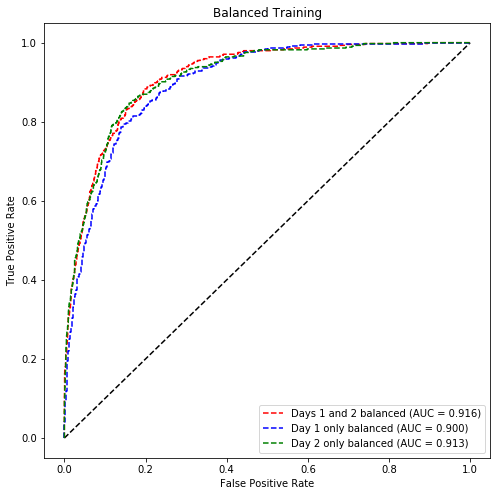

In [185]:
# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_48h_bal, tpr_48h_bal, label='Days 1 and 2 balanced (AUC = {:.3f})'.format(auc_48h_bal), c='red', ls='--')
plt.plot(fpr_D1_bal, tpr_D1_bal, label='Day 1 only balanced (AUC = {:.3f})'.format(auc_D1_bal), c='blue', ls='--')
plt.plot(fpr_D2_bal, tpr_D2_bal, label='Day 2 only balanced (AUC = {:.3f})'.format(auc_D2_bal), c='green', ls='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Balanced Training')
plt.legend(loc='lower right')
plt.savefig('balanced_roc_curves.png', bbox_inches='tight')
plt.show()

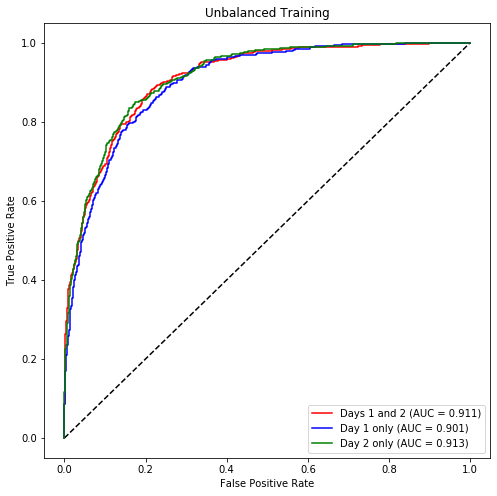

In [186]:
# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_48h, tpr_48h, label='Days 1 and 2 (AUC = {:.3f})'.format(auc_48h), c='red')
plt.plot(fpr_D1, tpr_D1, label='Day 1 only (AUC = {:.3f})'.format(auc_D1), c='blue')
plt.plot(fpr_D2, tpr_D2, label='Day 2 only (AUC = {:.3f})'.format(auc_D2), c='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Unbalanced Training')
plt.legend(loc='lower right')
plt.savefig('unbalanced_roc_curves.png', bbox_inches='tight')
plt.show()

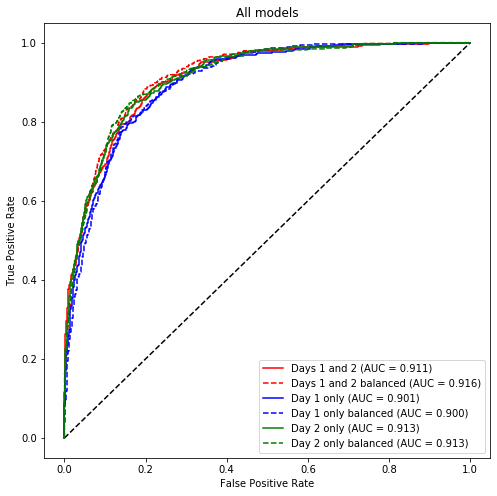

In [187]:
# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_48h, tpr_48h, label='Days 1 and 2 (AUC = {:.3f})'.format(auc_48h), c='red')
plt.plot(fpr_48h_bal, tpr_48h_bal, label='Days 1 and 2 balanced (AUC = {:.3f})'.format(auc_48h_bal), c='red', ls='--')
plt.plot(fpr_D1, tpr_D1, label='Day 1 only (AUC = {:.3f})'.format(auc_D1), c='blue')
plt.plot(fpr_D1_bal, tpr_D1_bal, label='Day 1 only balanced (AUC = {:.3f})'.format(auc_D1_bal), c='blue', ls='--')
plt.plot(fpr_D2, tpr_D2, label='Day 2 only (AUC = {:.3f})'.format(auc_D2), c='green')
plt.plot(fpr_D2_bal, tpr_D2_bal, label='Day 2 only balanced (AUC = {:.3f})'.format(auc_D2_bal), c='green', ls='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All models')
plt.legend(loc='lower right')
plt.savefig('all_roc_curves.png', bbox_inches='tight')
plt.show()

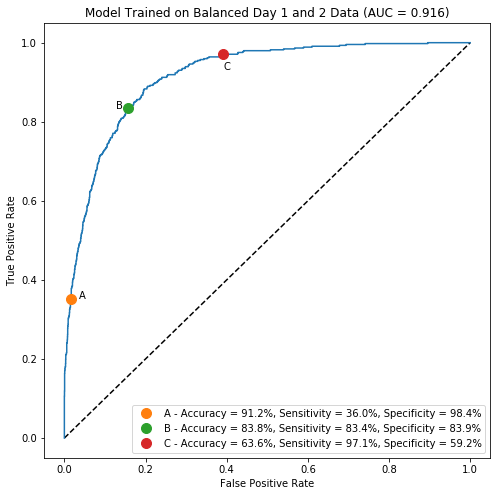

In [188]:
# Choose the three thresholds
thresh_A, thresh_B, thresh_C = 0.9, 0.5, 0.1
A = np.where(thresholds_48h_bal==thresholds_48h_bal[thresholds_48h_bal>=thresh_A][-1])
B = np.where(thresholds_48h_bal==thresholds_48h_bal[thresholds_48h_bal>=thresh_B][-1])
C = np.where(thresholds_48h_bal==thresholds_48h_bal[thresholds_48h_bal>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_test, y_pred_48h_bal[:]>thresh_A)
[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_test, y_pred_48h_bal[:]>thresh_B)
[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_test, y_pred_48h_bal[:]>thresh_C)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_48h_bal, tpr_48h_bal)
plt.plot(fpr_48h_bal[A], tpr_48h_bal[A],'.', markersize=20, label='A - Accuracy = {:.1f}%, Sensitivity = {:.1f}%, Specificity = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A)))
plt.annotate('A', (fpr_48h_bal[A]+0.02, tpr_48h_bal[A]))
plt.plot(fpr_48h_bal[B], tpr_48h_bal[B],'.', markersize=20, label='B - Accuracy = {:.1f}%, Sensitivity = {:.1f}%, Specificity = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B)))
plt.annotate('B', (fpr_48h_bal[B]-0.03, tpr_48h_bal[B]))
plt.plot(fpr_48h_bal[C], tpr_48h_bal[C],'.', markersize=20, label='C - Accuracy = {:.1f}%, Sensitivity = {:.1f}%, Specificity = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C)))
plt.annotate('C', (fpr_48h_bal[C], tpr_48h_bal[C]-0.04))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Trained on Balanced Day 1 and 2 Data (AUC = {:.3f})'.format(auc_48h_bal))
plt.legend(loc='lower right')
plt.savefig('best_model.png', bbox_inches='tight')
plt.show()

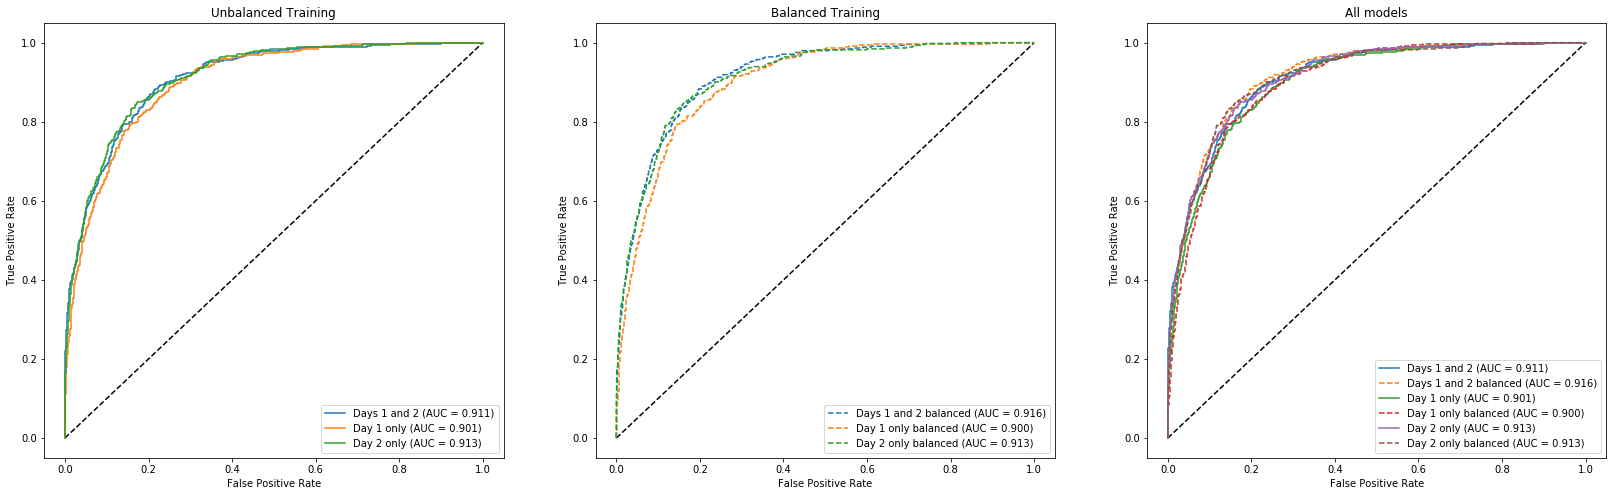

In [117]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28,8))

# Plot the unbalanced training models
ax1.plot([0, 1], [0, 1], 'k--')
ax1.plot(fpr_48h, tpr_48h, label='Days 1 and 2 (AUC = {:.3f})'.format(auc_48h))
ax1.plot(fpr_D1, tpr_D1, label='Day 1 only (AUC = {:.3f})'.format(auc_D1))
ax1.plot(fpr_D2, tpr_D2, label='Day 2 only (AUC = {:.3f})'.format(auc_D2))
ax1.set(title='Unbalanced Training', ylabel='True Positive Rate', xlabel='False Positive Rate')
ax1.legend(loc='lower right')

# Plot the balanced training models
ax2.plot([0, 1], [0, 1], 'k--')
ax2.plot(fpr_48h_bal, tpr_48h_bal, label='Days 1 and 2 balanced (AUC = {:.3f})'.format(auc_48h_bal), ls='--')
ax2.plot(fpr_D1_bal, tpr_D1_bal, label='Day 1 only balanced (AUC = {:.3f})'.format(auc_D1_bal), ls='--')
ax2.plot(fpr_D2_bal, tpr_D2_bal, label='Day 2 only balanced (AUC = {:.3f})'.format(auc_D2_bal), ls='--')
ax2.set(title='Balanced Training', ylabel='True Positive Rate', xlabel='False Positive Rate')
ax2.legend(loc='lower right')

# Plot all models together
ax3.plot([0, 1], [0, 1], 'k--')
ax3.plot(fpr_48h, tpr_48h, label='Days 1 and 2 (AUC = {:.3f})'.format(auc_48h))
ax3.plot(fpr_48h_bal, tpr_48h_bal, label='Days 1 and 2 balanced (AUC = {:.3f})'.format(auc_48h_bal), ls='--')
ax3.plot(fpr_D1, tpr_D1, label='Day 1 only (AUC = {:.3f})'.format(auc_D1))
ax3.plot(fpr_D1_bal, tpr_D1_bal, label='Day 1 only balanced (AUC = {:.3f})'.format(auc_D1_bal), ls='--')
ax3.plot(fpr_D2, tpr_D2, label='Day 2 only (AUC = {:.3f})'.format(auc_D2))
ax3.plot(fpr_D2_bal, tpr_D2_bal, label='Day 2 only balanced (AUC = {:.3f})'.format(auc_D2_bal), ls='--')
ax3.set(title='All models', ylabel='True Positive Rate', xlabel='False Positive Rate')
ax3.legend(loc='lower right')

plt.savefig('roc_curves.png', bbox_inches='tight')
plt.show()

In [63]:
# Write a function that plots nice confusion matrices
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm[0][0] = round(cm[0][0],2)
        cm[0][1] = round(cm[0][1],2)
        cm[1][0] = round(cm[1][0],2)
        cm[1][1] = round(cm[1][1],2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

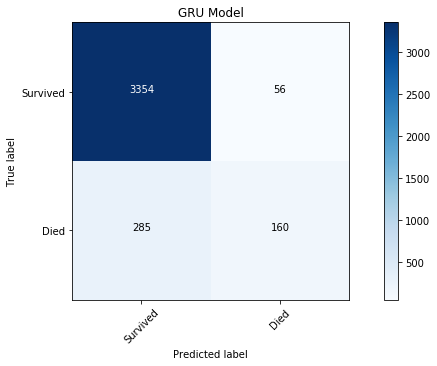

In [189]:
# Calculate the confusion matrix
decision_threshold = thresh_A
cm = confusion_matrix(y_test, y_pred_48h_bal[:]>decision_threshold)
plot_confusion_matrix(cm, ['Survived', 'Died'], normalize=False, title='GRU Model')